In [152]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

Let us first set the precision level for our floating point operations.

In [153]:
eps = 1e-6

The following is a function to assess the success probability of player **idx_player** given the players' choices were **nums** and **C** is the discretization parameter.

In [154]:
def grade_position(nums, idx_player, C):
    N = len(nums)
    if N == 1:
        return C
    nums_sorted = sorted(nums)
    idx = nums_sorted.index(nums[idx_player])
    if idx == 0:
        return (nums_sorted[0] + nums_sorted[1])/2
    elif idx == N-1:
        return C - (nums_sorted[-1] + nums_sorted[-2])/2
    else:
        return (nums_sorted[idx+1] - nums_sorted[idx-1])/2 

In [155]:
# Just an auxiliary function to make a one level flattening of a list
def my_flatten(l):
    return [item for sublist in l for item in sublist]

That's the recursive function to find the distribution of optimal moves for player **i** given that **N** players are playing and until now moves **memory** have been performed. Again **C** is the discretization parameter. 
The variable **history** is used to store the history of possible success probabilities for different moves of the first player. It is used for visualization purposes (see below).

In [156]:
def searchRec(N, i, C, memory, history):
    # All players have already made a move 
    if i==N:
        return [([],1.0)], 0

    # Still there's moves to make
    # Here are the possible moves for player i
    possible_choices = [elem for elem in range(0,C+1) if elem not in memory]
    # Be verbose if i==0
    if i == 0:
        possible_choices = tqdm(possible_choices)
    solutions_current = []
    val_current = -1
    for elem in possible_choices:
        memory.append(elem)
        # Compute the value for next players if ith player plays elem
        solutions_next, _ = searchRec(N, i+1, C, memory, history)
        # What's the success probability then?
        val_elem = sum([p*grade_position(memory + solution[::-1], i, C) for solution, p in solutions_next])
        if i==0:
            history.append(val_elem/C)
        # Update the current candidate for the final result
        # Be careful with floating point operations
        if val_elem > val_current + eps:
            val_current = val_elem
            for l, p in solutions_next:
                l.append(elem)
            solutions_current = [solutions_next]
        # Careful again:)
        elif abs(val_elem - val_current)<eps:
            for l, p in solutions_next:
                l.append(elem)
            solutions_current.append(solutions_next)
        memory.pop()
    # divide the probabilities
    K = len(solutions_current)
    solutions_current = my_flatten(solutions_current)
    # We need to correct the distributionS for ith player if he has K beneficial choices.
    return [(solution, p/K) for solution, p in solutions_current], val_current

In [157]:
# Just a wrapper on the above to compute all relevant information for player zero.
def getBest(N, C):
    memory = []
    history = []
    list_solutions, val = searchRec(N, 0, C, memory, history)
    best_first_temp = set([solution[-1] for solution, p in list_solutions]) 
    best_first = sorted([elem/C for elem in best_first_temp])
    solutions = [[elem/C for elem in l[::-1]] for l, _ in list_solutions]
    return (best_first, val/C, solutions, history)

In [158]:
num_players = 4
C = 100

In [162]:
%%time 
(best_for_first, val, list_solutions, history) = getBest(num_players,C)

100%|██████████| 101/101 [02:29<00:00,  1.48s/it]

CPU times: user 2min 29s, sys: 342 ms, total: 2min 29s
Wall time: 2min 29s


In [163]:
print(f"Best moves for first player are: {best_for_first}")
print(f"Success probability is then: {val}")
print(f"Some possible game scenarios: {random.choices(list_solutions,k=min([10, len(list_solutions)]))}")

Best moves for first player are: [0.17, 0.83]
Success probability is then: 0.2925000000000001
Some possible game scenarios: [[0.83, 0.17, 0.5, 0.84], [0.17, 0.83, 0.5, 0.33], [0.83, 0.17, 0.5, 0.77], [0.17, 0.83, 0.5, 0.76], [0.17, 0.83, 0.5, 0.54], [0.17, 0.83, 0.5, 0.56], [0.83, 0.17, 0.5, 0.53], [0.17, 0.83, 0.5, 0.59], [0.17, 0.83, 0.5, 0.62], [0.17, 0.83, 0.5, 0.67]]


Based on the history computed above we plot the success probabilities for different choices of the first move.

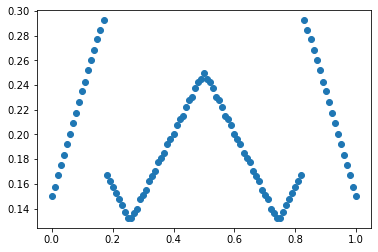

In [164]:
plt.scatter(x=np.linspace(0,1.0,C+1),y=history)